In [2]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/dan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dan/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
import json
with open('states.json') as f:
    states = json.load(f)
with open('countries.json') as f:
    countries = json.load(f)

In [4]:
# Make PCA components part of the non-text model
# count number of entries that appear to have a state or country
def expresses_locality(string):
    #for title in data['request_title']:
    for state in states.values():
        if state.lower() in string.lower():
            #state_n += 1
            return True
    for country in countries.values():
        if country.lower() in string.lower():
            #country_n += 1
            return True
    for state_abbrev in states.keys():
        abbrevs = []
        abbrevs.append(", " + state_abbrev + " ")
        abbrevs.append("," + state_abbrev + " ")
        for abbrev in abbrevs:
            if abbrev in string:
                return True
    return False

## TODO: count the number of false identifications of states based on lower vs upper case
##      continue locality in title with cities
##      create new feature(s) based on locality

In [5]:
data = pd.read_json("train.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data['number_of_words_in_title']=data.apply(lambda x: len(x['request_title']), axis=1).astype(int)
data['number_of_words_in_text']=data.apply(lambda x: len(x['request_text']), axis=1).astype(int)
data['post_was_edited'] = data.apply(lambda x: 1 if "edit" in x['request_text'] else 0, axis=1).astype(int)
data['locality_in_title']=data.apply(lambda x: 1 if expresses_locality(x['request_title']) else 0, axis=1).astype(int)
data['locality_in_text']=data.apply(lambda x: 1 if expresses_locality(x['request_text']) else 0, axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)
data=data.drop(['requester_user_flair'], axis=1)
#data['requester_user_flair'] = data['requester_user_flair'].replace([None],"none")
#data['requester_user_flair'] = data['requester_user_flair'].astype("category").cat.codes
data.head(3)

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_number_of_comments_at_retrieval,request_text,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,...,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,year,month,day,dayofweek,number_of_words_in_title,number_of_words_in_text,locality_in_title,locality_in_text
0,0,1,0,0,Hi I am in need of food for my 4 children we a...,0.0000,792.420405,0.0,792.420405,0,...,0,1,2011,10,5,2,39,316,1,0
1,2,5,0,0,I spent the last money I had on gas today. Im ...,501.1111,1122.279838,0.0,621.127072,0,...,116,11168,2012,3,25,6,57,74,1,0
2,0,3,0,0,My girlfriend decided it would be a good idea ...,0.0000,771.616181,0.0,771.616181,0,...,0,3,2011,10,26,2,66,277,0,0


In [6]:
data.groupby(['locality_in_title']).size()

locality_in_title
0    3093
1     947
dtype: int64

In [50]:
from sklearn.cross_validation import train_test_split

train_data, dev_data = train_test_split(data, test_size=0.3)
train_labels = train_data["requester_received_pizza"]
dev_labels = dev_data["requester_received_pizza"]
train_data=train_data.drop(['requester_received_pizza'], axis=1)
dev_data=dev_data.drop(['requester_received_pizza'], axis=1)

train_data_text = train_data["request_text"]
train_data=train_data.drop(['request_text'], axis=1)
dev_data_text = dev_data["request_text"]
dev_data=dev_data.drop(['request_text'], axis=1)

print (train_data.shape)
print (train_data_text.shape)
print (dev_data.shape)
print (dev_data_text.shape)

(2828, 29)
(2828,)
(1212, 29)
(1212,)


# Correlations

In [51]:
# Add train_data and labels to new dataframe to determine correlation matrix
data_for_corr = train_data.copy()
data_for_corr['requester_received_pizza'] = train_labels

corr_matrix = data_for_corr.corr()
corr_matrix['requester_received_pizza'].sort_values(ascending=False)

requester_received_pizza                                1.000000
requester_number_of_posts_on_raop_at_retrieval          0.447403
requester_number_of_comments_in_raop_at_retrieval       0.294179
request_number_of_comments_at_retrieval                 0.282129
requester_number_of_comments_in_raop_at_request         0.147721
requester_days_since_first_post_on_raop_at_retrieval    0.139861
requester_number_of_posts_on_raop_at_request            0.135854
number_of_words_in_text                                 0.119720
requester_account_age_in_days_at_retrieval              0.115061
requester_number_of_comments_at_retrieval               0.114274
requester_days_since_first_post_on_raop_at_request      0.094453
number_of_upvotes_of_request_at_retrieval               0.088445
requester_upvotes_minus_downvotes_at_retrieval          0.074862
post_was_edited                                         0.052331
requester_number_of_posts_at_retrieval                  0.050054
requester_upvotes_plus_do

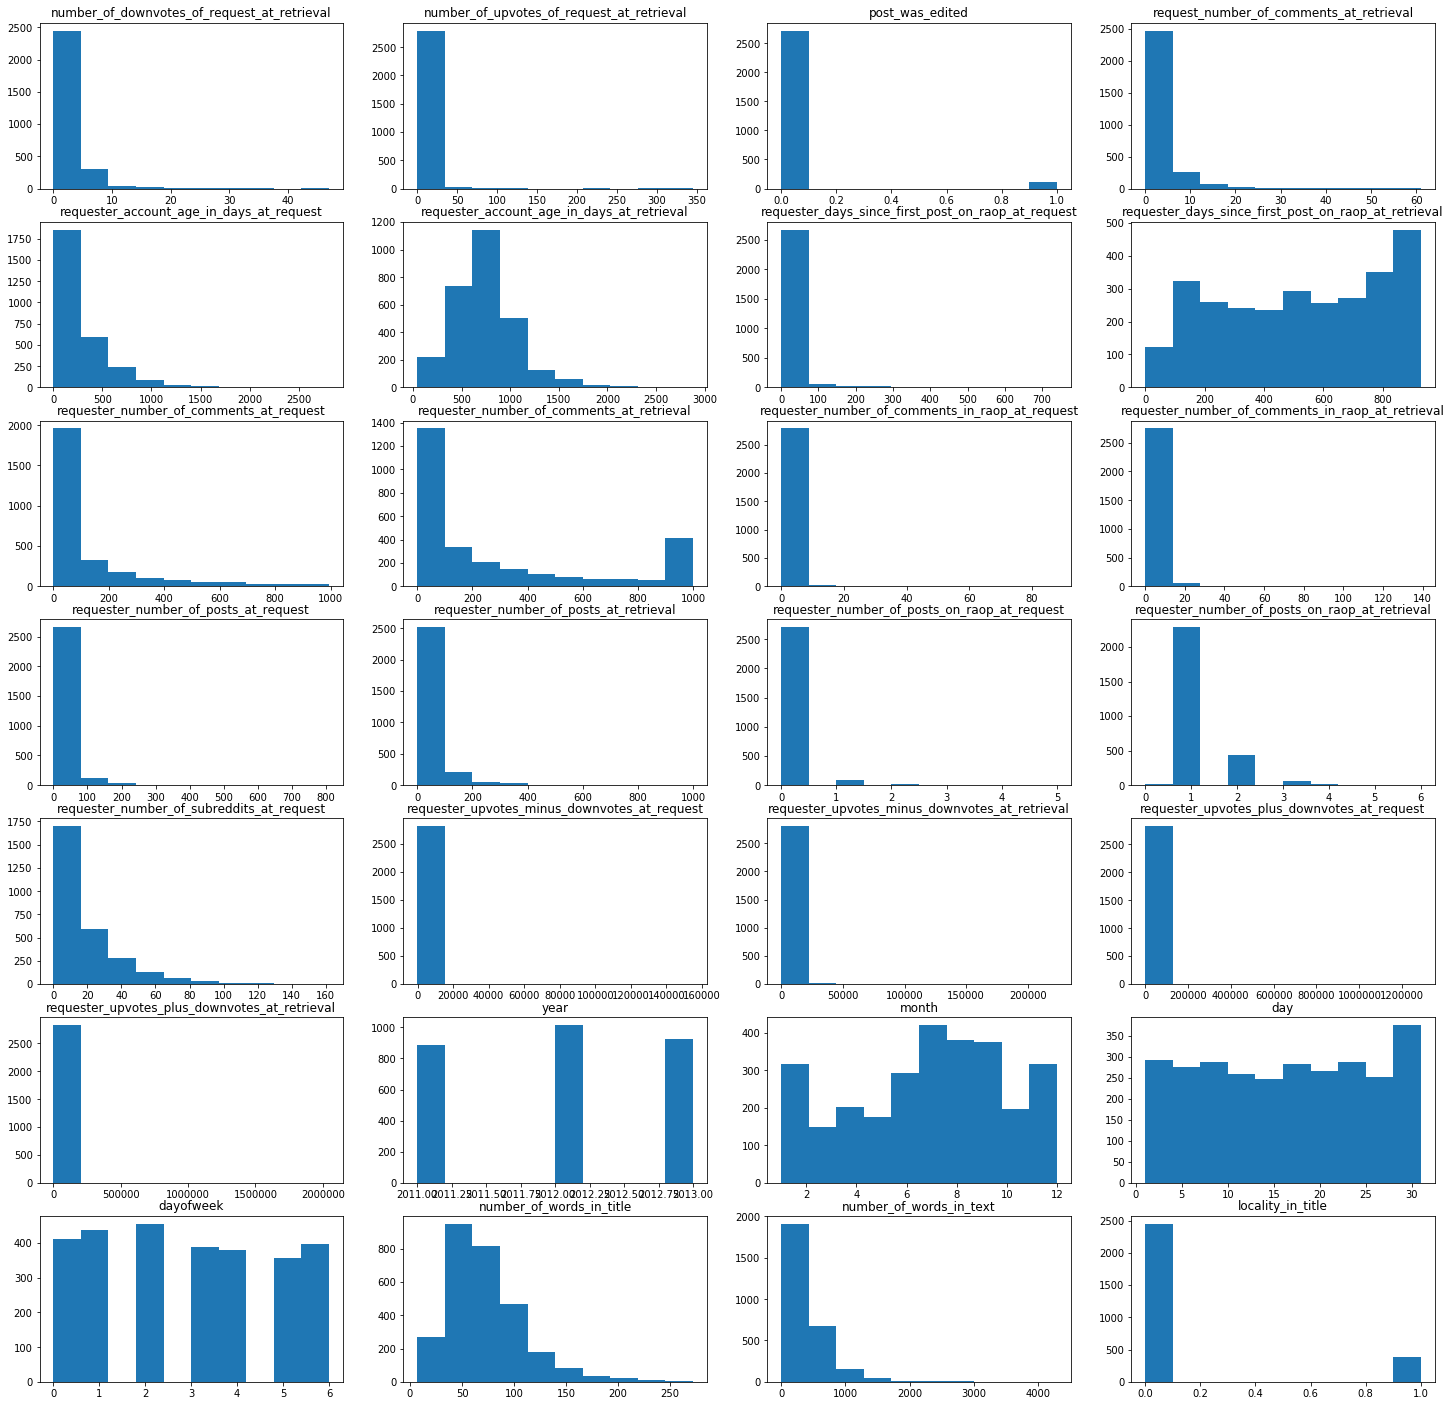

In [37]:
rows = 7
cols = 4

num_columns = []
for column in list(train_data):
    if train_data[column].dtype in {np.dtype('int64'),np.dtype('float64'),np.dtype('bool'),np.dtype('int8')}: 
        num_columns.append(column)
        
f, axarr = plt.subplots(rows,cols,figsize=(25,25))

column = 0
for row in range(rows):
    for col in range(cols):
        axarr[row,col].hist(train_data[num_columns[column]])
        axarr[row,col].set_title(num_columns[column])
        column += 1
        if column > len(num_columns)-1:
            break

plt.show()

In [52]:
lr = LogisticRegression().fit(train_data,train_labels)
y_pred = lr.predict(dev_data)
print "Accuracy = %1.3f" % lr.score(dev_data,dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.822
             precision    recall  f1-score   support

      False       0.83      0.96      0.89       912
       True       0.77      0.40      0.53       300

avg / total       0.81      0.82      0.80      1212



In [53]:
columns = ['requester_number_of_posts_on_raop_at_retrieval']

lr1 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr1.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr1.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.847
             precision    recall  f1-score   support

      False       0.87      0.94      0.90       912
       True       0.75      0.57      0.65       300

avg / total       0.84      0.85      0.84      1212



In [54]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval']

lr2 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr2.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr2.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.850
             precision    recall  f1-score   support

      False       0.85      0.96      0.91       912
       True       0.82      0.50      0.62       300

avg / total       0.85      0.85      0.84      1212



In [55]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval']

lr3 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr3.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr3.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.848
             precision    recall  f1-score   support

      False       0.86      0.96      0.90       912
       True       0.81      0.51      0.62       300

avg / total       0.84      0.85      0.84      1212



In [56]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval']

lr4 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr4.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr4.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.842
             precision    recall  f1-score   support

      False       0.85      0.96      0.90       912
       True       0.79      0.49      0.61       300

avg / total       0.84      0.84      0.83      1212



In [57]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request']

lr5 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr5.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr5.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.841
             precision    recall  f1-score   support

      False       0.85      0.96      0.90       912
       True       0.78      0.49      0.61       300

avg / total       0.83      0.84      0.83      1212



In [58]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval']

lr6 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr6.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr6.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.838
             precision    recall  f1-score   support

      False       0.85      0.95      0.90       912
       True       0.78      0.49      0.60       300

avg / total       0.83      0.84      0.82      1212



In [47]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval',
            'number_of_words_in_text']

lr7 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr7.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr7.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.823
             precision    recall  f1-score   support

      False       0.84      0.94      0.89       917
       True       0.72      0.45      0.55       295

avg / total       0.81      0.82      0.81      1212



In [48]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval',
            'requester_number_of_comments_in_raop_at_retrieval',
            'number_of_upvotes_of_request_at_retrieval',
            'requester_number_of_comments_in_raop_at_request',
            'requester_days_since_first_post_on_raop_at_retrieval',
            'number_of_words_in_text',
            'requester_account_age_in_days_at_retrieval']

lr8 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr8.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr8.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.822
             precision    recall  f1-score   support

      False       0.84      0.94      0.89       917
       True       0.72      0.44      0.55       295

avg / total       0.81      0.82      0.81      1212

